## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import fbeta_score, roc_auc_score

from skopt import BayesSearchCV

import shap

import warnings
warnings.filterwarnings("ignore")

## Read Dataset

In [2]:
data = pd.read_csv("data/Heart_Disease_Kaggle_Preprocessed.csv")
print(data.shape)
data.head()

(268, 14)


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,ECG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,1.733026,0.681528,0.871534,-0.064103,1.407389,-0.418854,0.977857,-1.777056,-0.699206,1.193857,0.680101,2.462874,-0.881493,1
1,1.400801,-1.467290,-0.180588,-0.914581,6.109512,-0.418854,0.977857,0.437459,-0.699206,0.491048,0.680101,-0.715538,1.181740,0
2,0.293383,0.681528,-1.232710,-0.404294,0.222143,-0.418854,-1.022644,-0.387556,-0.699206,-0.651016,-0.947283,-0.715538,1.181740,1
3,1.068576,0.681528,0.871534,-0.177500,0.261004,-0.418854,-1.022644,-1.950743,1.430194,-0.738867,0.680101,0.343933,1.181740,0
4,2.175994,-1.467290,-1.232710,-0.631088,0.377585,-0.418854,0.977857,-1.255994,1.430194,-0.738867,-0.947283,0.343933,-0.881493,0


## Data split

In [3]:
X = data.drop(columns=["Heart Disease"])
y = data["Heart Disease"]

## Cross-validation with Bayesian Optimization

In [4]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_space = {
    "n_neighbors": (1, 50),  # Number of neighbors
    "weights": ["uniform", "distance"],  # Weight function
    "p": (1, 2)
}

lr_opt = BayesSearchCV(
    KNeighborsClassifier(),
    search_spaces=search_space,
    scoring="roc_auc",
    n_iter=30,
    n_jobs=-1,
    random_state=42
)

In [5]:
fold_results = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train_full, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_full, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)
    
    # Fit
    lr_opt.fit(X_train, y_train)
    
    # Best model
    best_model = lr_opt.best_estimator_
    y_pred = best_model.predict(X_val)
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]
    
    # Metrics on outer fold
    fold_metrics = {
        "fold": fold + 1,
        "accuracy": accuracy_score(y_val, y_pred),
        "precision": precision_score(y_val, y_pred),
        "recall": recall_score(y_val, y_pred),
        "fbeta_2": fbeta_score(y_val, y_pred, beta=2),
        "roc_auc": roc_auc_score(y_val, y_pred_proba),
        "best_params": lr_opt.best_params_
    }
    
    fold_results.append(fold_metrics)
    
    print(f"Fold {fold+1}: { {k: round(v, 3) if isinstance(v, float) else v for k, v in fold_metrics.items()} }")

# Compute mean scores
print("\nMean scores across folds:")
for metric in ["accuracy", "precision", "recall", "fbeta_2", "roc_auc"]:
    values = [f[metric] for f in fold_results]
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")
    

Fold 1: {'fold': 1, 'accuracy': 0.889, 'precision': 0.95, 'recall': 0.792, 'fbeta_2': 0.819, 'roc_auc': np.float64(0.969), 'best_params': OrderedDict([('n_neighbors', 50), ('p', 1), ('weights', 'distance')])}
Fold 2: {'fold': 2, 'accuracy': 0.907, 'precision': 1.0, 'recall': 0.792, 'fbeta_2': 0.826, 'roc_auc': np.float64(0.962), 'best_params': OrderedDict([('n_neighbors', 50), ('p', 1), ('weights', 'distance')])}
Fold 3: {'fold': 3, 'accuracy': 0.778, 'precision': 0.773, 'recall': 0.708, 'fbeta_2': 0.72, 'roc_auc': np.float64(0.856), 'best_params': OrderedDict([('n_neighbors', 50), ('p', 1), ('weights', 'distance')])}
Fold 4: {'fold': 4, 'accuracy': 0.679, 'precision': 0.684, 'recall': 0.542, 'fbeta_2': 0.565, 'roc_auc': np.float64(0.753), 'best_params': OrderedDict([('n_neighbors', 21), ('p', 2), ('weights', 'distance')])}
Fold 5: {'fold': 5, 'accuracy': 0.887, 'precision': 0.87, 'recall': 0.87, 'fbeta_2': 0.87, 'roc_auc': np.float64(0.961), 'best_params': OrderedDict([('n_neighbors',

## Feature Importance | SHAP

In [6]:
# Step 1: Find the best fold by ROC AUC
best_fold = max(fold_results, key=lambda x: x["roc_auc"])

# Step 2: Extract best parameters
best_params = best_fold["best_params"]

# Step 3: Create new GaussianNB with best parameters
knn = KNeighborsClassifier(**best_params)

print(best_params)

OrderedDict([('n_neighbors', 50), ('p', 1), ('weights', 'distance')])


Using 214 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/54 [00:00<?, ?it/s]

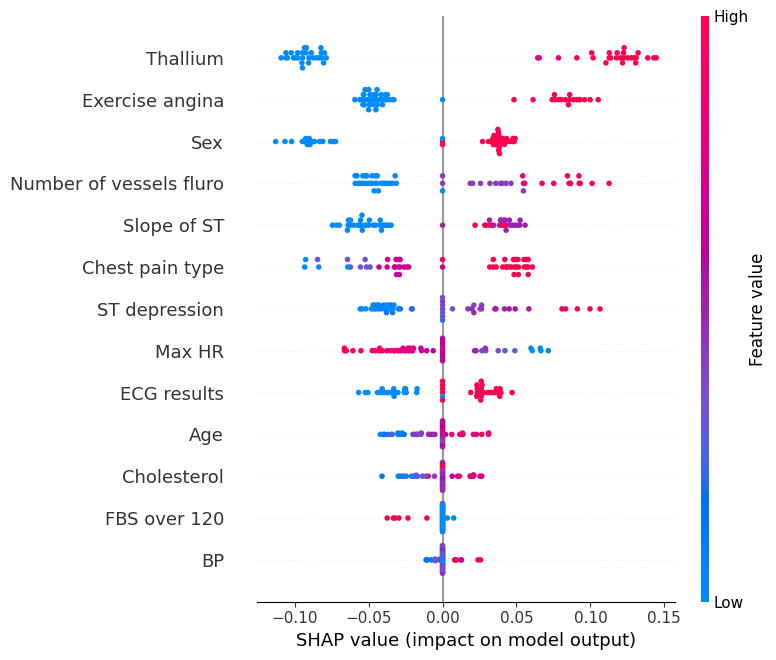

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Train nb model
knn.fit(X_train, y_train)

# Sample for SHAP
X_sample = X_test # X_test[:10]

# Use only the class 1 probability output for SHAP
predict_fn = lambda x: knn.predict_proba(x)[:, 1]

# KernelExplainer
explainer = shap.KernelExplainer(predict_fn, X_train) # X_train[:100]
shap_values = explainer.shap_values(X_sample)

# Plot
shap.summary_plot(shap_values, X_sample, feature_names=X.columns)